# Cs  calibration notebook

Description pending

### Imports and settings

In [40]:
# Toggle data location
local_data = True

In [41]:
# General definitions
%run '../definitions.ipynb'

# Contains the ExtraProperties for S1 and S2 saturation
%run '../treemakers.ipynb'

### Read data

In [42]:
if local_data:
    processed_data_path = '/home/erik/win/data/xams_run8/processed/low_pmt_gain/'
    minitree_path = '/home/erik/win/data/xams_run8/minitrees/'
else:
    processed_data_path = '/data/xenon/xams/run8/processed/data/'
    minitree_path = '/data/xenon/xams/run8/minitrees/'

In [43]:
run_names_cs = get_run_list(processed_data_path, '170323_152801', '170323_154257')
run_names_na = get_run_list(processed_data_path, '170323_155714', '170323_161452')

Run list contains 3 files
Run list contains 3 files


In [44]:
hax.init(
    # Always use these lines to tell hax that we don't care about Xe1T
    experiment='XAMS', 
    pax_version_policy='loose', use_runs_db = False,
    # Here come the useful settings
    main_data_paths = [processed_data_path, '/home/erik'],
    minitree_paths = [minitree_path],       
         )

In [45]:
d_cs = hax.minitrees.load(run_names_cs, ['Basics', ExtraS1S2Properties])
# Annoying ns timebase
d_cs['drift_time'] = d_cs['drift_time'] * 1e-3

## Basic cuts

### Require interaction

In [46]:
d_cs = cuts.isfinite(d_cs, 's1')

Finite s1 selection: 10276 rows removed (91.80% passed)


In [47]:
# Enable to see how how the spectrum looks

# plt.hist2d(d_cs['s1'], d_cs['s2'], bins=100, norm=LogNorm(), range=((0, 400), (0, 60e3)))
# plt.xlabel('raw S1 (a.u.)')
# plt.ylabel('raw S2 (a.u.)')
# plt.title('After single scatter + threshold cuts, raw s1/s2')
# plt.colorbar()
# plt.show()

### Single scatter

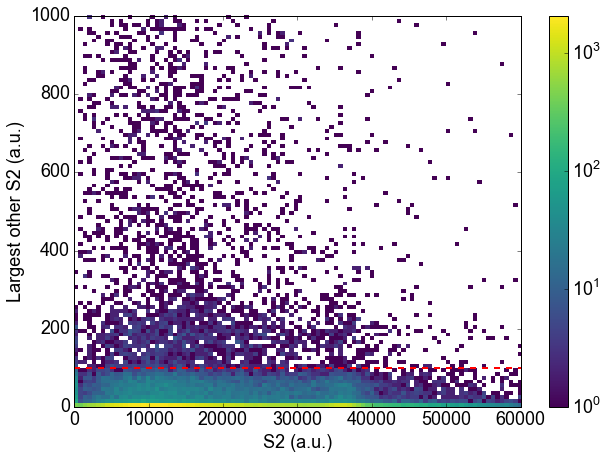

In [48]:
plt.hist2d(d_cs['s2'], d_cs['largest_other_s2'], bins=100, norm=LogNorm(), range=((0, 60e3), (0, 1e3)))
plt.axhline(100, color='red', ls='--',lw=2)
plt.xlabel('S2 (a.u.)')
plt.ylabel('Largest other S2 (a.u.)')
plt.colorbar()
plt.show()

In [49]:
d_cs = cuts.below(d_cs, 'largest_other_s2', 100)

largest_other_s2 below 100 selection: 24949 rows removed (78.32% passed)


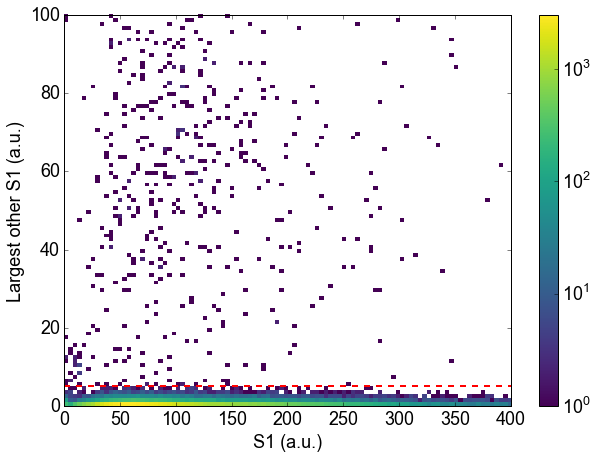

In [50]:
plt.hist2d(d_cs['s1'], d_cs['largest_other_s1'], bins=100, norm=LogNorm(), range=((0, 400), (0, 100)))
plt.axhline(5, color='red', ls='--',lw=2)
plt.xlabel('S1 (a.u.)')
plt.ylabel('Largest other S1 (a.u.)')
plt.colorbar()
plt.show()

In [51]:
d_cs = cuts.below(d_cs, 'largest_other_s1', 5)

largest_other_s1 below 5 selection: 979 rows removed (98.91% passed)


### Threshold

#### S2 threshold

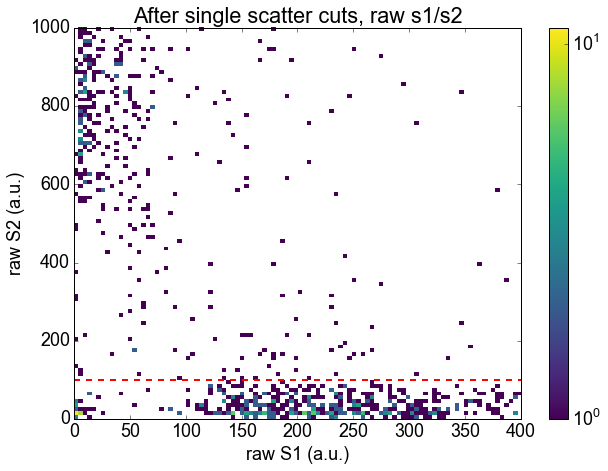

In [52]:
plt.hist2d(d_cs['s1'], d_cs['s2'], bins=100, norm=LogNorm(), range=((0, 400), (0, 1e3)))
plt.xlabel('raw S1 (a.u.)')
plt.ylabel('raw S2 (a.u.)')
plt.title('After single scatter cuts, raw s1/s2')
plt.colorbar()
plt.axhline(100, color='red', lw=2,ls='--')
plt.show()

#### S1 threshold

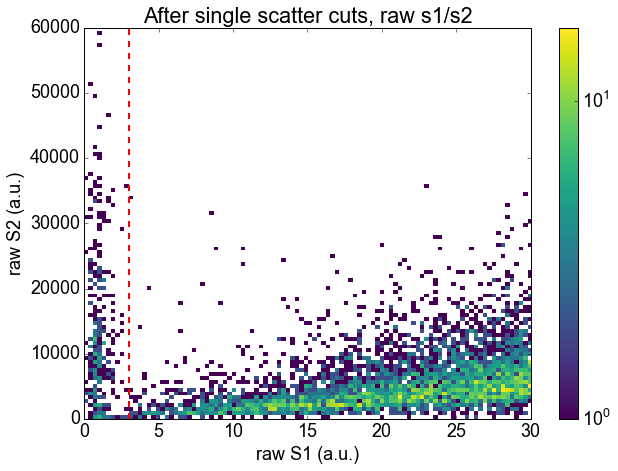

In [53]:
plt.hist2d(d_cs['s1'], d_cs['s2'], bins=100, norm=LogNorm(), range=((0, 30), (0, 60e3)))
plt.xlabel('raw S1 (a.u.)')
plt.ylabel('raw S2 (a.u.)')
plt.title('After single scatter cuts, raw s1/s2')
plt.colorbar()
plt.axvline(3, color='red', lw=2,ls='--')
plt.show()

In [54]:
d_cs = cuts.above(d_cs, 's2', 100)
d_cs = cuts.above(d_cs, 's1', 3)

s2 above 100 selection: 612 rows removed (99.31% passed)
s1 above 3 selection: 316 rows removed (99.64% passed)


In [55]:
# Enable to see how how the spectrum looks now

# plt.hist2d(d_cs['s1'], d_cs['s2'], bins=100, norm=LogNorm(), range=((0, 400), (0, 60e3)))
# plt.xlabel('raw S1 (a.u.)')
# plt.ylabel('raw S2 (a.u.)')
# plt.title('After single scatter + threshold cuts, raw s1/s2')
# plt.colorbar()
# plt.show()

### Saturation

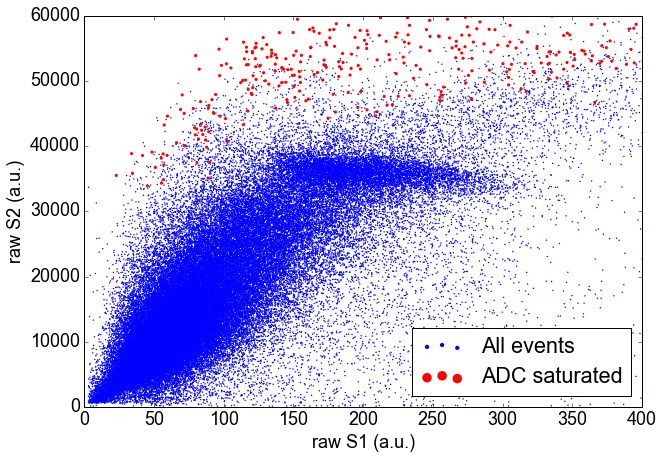

In [56]:
sat = (d_cs['s1_n_saturated_channels'] > 0) | (d_cs['s2_n_saturated_channels'] > 0)

plt.scatter(d_cs['s1'], d_cs['s2'], edgecolor='None', s=2, label='All events')
plt.scatter(d_cs['s1'][sat], d_cs['s2'][sat], edgecolor='None', s=10, color='red', label='ADC saturated')
plt.legend(loc='lower right', markerscale=3)
plt.xlim(0, 400)
plt.ylim(0, 60e3)
plt.xlabel('raw S1 (a.u.)')
plt.ylabel('raw S2 (a.u.)')
plt.show()


In [57]:
d_cs = cuts.below(d_cs, 's1_n_saturated_channels', 1)
d_cs = cuts.below(d_cs, 's2_n_saturated_channels', 1)

s1_n_saturated_channels below 1 selection: 90 rows removed (99.90% passed)
s2_n_saturated_channels below 1 selection: 388 rows removed (99.56% passed)


### S1 AFT

In [58]:
x, y = get_trend(d_cs['drift_time'], d_cs['s1_area_fraction_top'], (0, 60), 60)
f_s1_aft = my_interp(x, y)

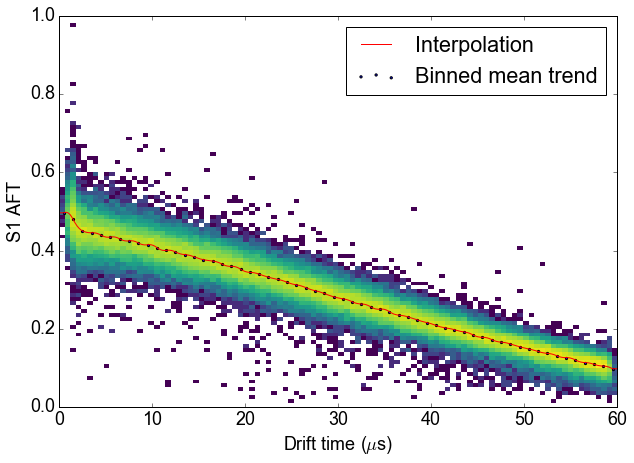

In [59]:
plt.hist2d(d_cs['drift_time'], d_cs['s1_area_fraction_top'], bins=100, norm=LogNorm(), range=((0, 60), (0,1)))
x_plot = np.linspace(0, 60, 250)
plt.plot(x_plot, f_s1_aft(x_plot), color='red', label='Interpolation')
plt.scatter(x, y, s=5, label='Binned mean trend')
plt.xlabel('Drift time ($\mu$s)')
plt.ylabel('S1 AFT')
plt.legend()
plt.show()

You might be tempted to throw the outliers in this plot out... However, consider this: if an S1 is small, the spread in AFT gets larger. We have to make an S1-area dependent cut out of this! How:
  * First get the trend and compute the devitation from the trend
  * Plot the deviation from the trend and cut on that parameter

In [60]:
# Compute the difference from the trend
d_cs['s1_aft_difference'] = d_cs['s1_area_fraction_top'] - f_s1_aft(d_cs['drift_time'])

In [61]:
# Get the upper and lower percentiles...
x, y_upper = get_trend(d_cs['s1'], d_cs['s1_aft_difference'], bins=20, x_range=(0, 400), mode='percentile', pct=95)
x, y_lower = get_trend(d_cs['s1'], d_cs['s1_aft_difference'], bins=20, x_range=(0, 400), mode='percentile',pct=5)

# ... And their interpolation...
f_lower = my_interp(x, y_lower, kind='cubic')
f_upper = my_interp(x, y_upper, kind='cubic')

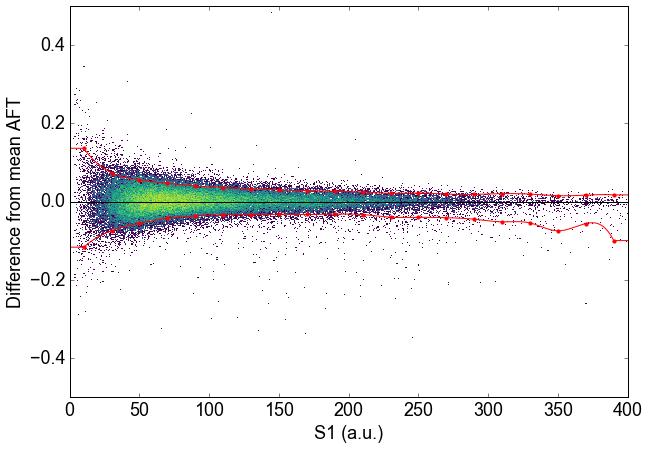

In [62]:
plt.hist2d(d_cs['s1'], d_cs['s1_aft_difference'], bins=500, range=((0, 400), (-0.5, 0.5)), norm=LogNorm())
plt.axhline(0, color='black')
x_plot = np.linspace(0, 400, 400)

plt.plot(x_plot, f_upper(x_plot), color='red', label='Interpolation')
plt.plot(x_plot, f_lower(x_plot), color='red')
plt.scatter(x, y_upper, s=10, color='red', label='Binned percentile')
plt.scatter(x, y_lower, s=10, color='red')
plt.xlabel('S1 (a.u.)')
plt.ylabel('Difference from mean AFT')
plt.show()

In [63]:
d_cs['AFT_Upper'] = (d_cs['s1_aft_difference'] < f_upper(d_cs['s1'])) # Add boolean variable
d_cs['AFT_Lower'] = (d_cs['s1_aft_difference'] > f_lower(d_cs['s1']))
d_cs = cuts.selection(d_cs, d_cs['AFT_Upper'], 'AFT_Upper')
d_cs = cuts.selection(d_cs, d_cs['AFT_Lower'], 'AFT_Lower')

AFT_Upper selection: 4353 rows removed (95.04% passed)
AFT_Lower selection: 4392 rows removed (94.73% passed)


### Drift time

In [64]:
d_cs = cuts.range_selection(d_cs, 'drift_time', (0, 60e3))

drift_time in [0, 60000.0) selection: 0 rows removed (100.00% passed)


## What we have got so far

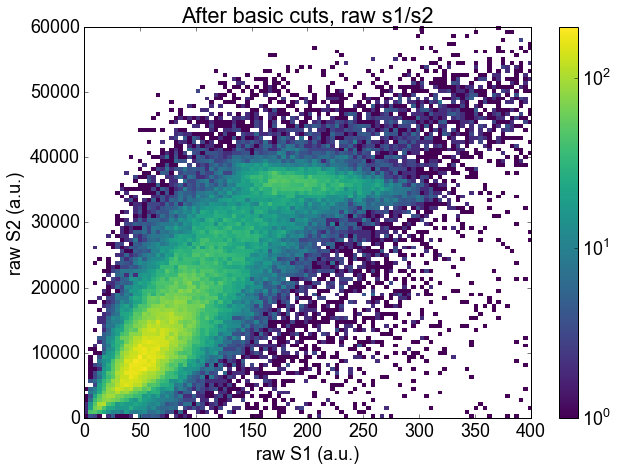

In [65]:
plt.hist2d(d_cs['s1'], d_cs['s2'], bins=100, norm=LogNorm(), range=((0, 400), (0, 60e3)))
plt.xlabel('raw S1 (a.u.)')
plt.ylabel('raw S2 (a.u.)')
plt.title('After basic cuts, raw s1/s2')
plt.colorbar()
plt.show()

In [66]:
cuts.history(d_cs)

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,Finite s1,125339,115063,10276,0.918014,0.918014
1,largest_other_s2 below 100,115063,90114,24949,0.783171,0.718962
2,largest_other_s1 below 5,90114,89135,979,0.989136,0.711151
3,s2 above 100,89135,88523,612,0.993134,0.706269
4,s1 above 3,88523,88207,316,0.996430,0.703747
5,s1_n_saturated_channels below 1,88207,88117,90,0.998980,0.703029
6,s2_n_saturated_channels below 1,88117,87729,388,0.995597,0.699934
7,AFT_Upper,87729,83376,4353,0.950381,0.665204
8,AFT_Lower,83376,78984,4392,0.947323,0.630163
9,"drift_time in [0, 60000.0)",78984,78984,0,1.000000,0.630163


## Corrections

### S1 light yield correction

For the light yield correction, we do the following: 
  * Select the photopeak based on the S2
  * Plot as function of z
  * Bin based on mean
  * Interpolate

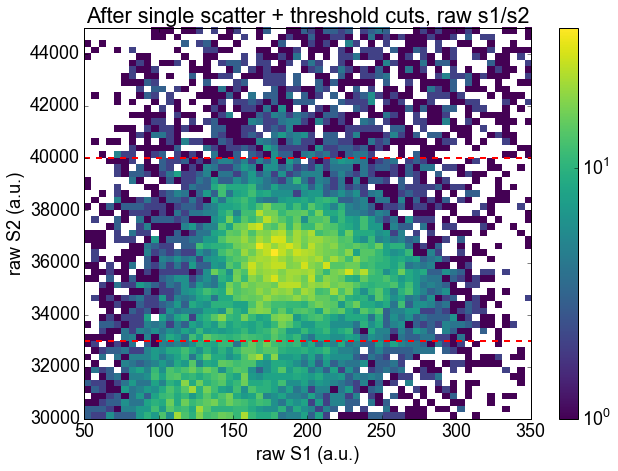

In [67]:
plt.hist2d(d_cs['s1'], d_cs['s2'], bins=60, norm=LogNorm(), range=((50, 350), (30e3, 45e3)))
plt.xlabel('raw S1 (a.u.)')
plt.ylabel('raw S2 (a.u.)')
plt.title('After single scatter + threshold cuts, raw s1/s2')
plt.colorbar()
#draw_box((120, 320), (33e3, 40e3), edgecolor='red', lw=1.5)
for l in (33e3, 40e3):
    plt.axhline(l, ls='--' ,lw=2, color='red')
plt.show()

In [68]:
d = deepcopy(d_cs)
d = cuts.range_selection(d, 's2', (33e3, 40e3))

s2 in [33000.0, 40000.0) selection: 69270 rows removed (12.30% passed)


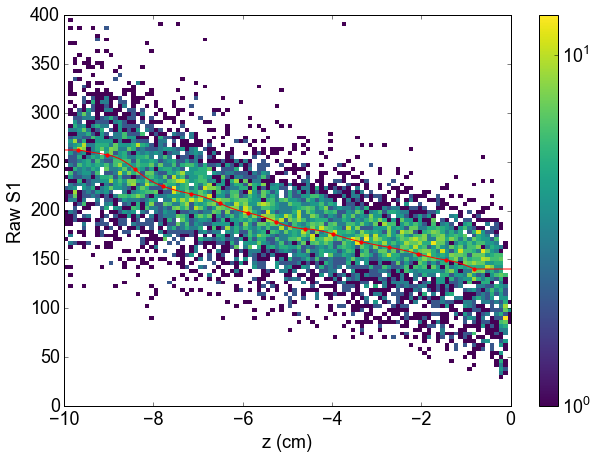

In [69]:
x,y = get_trend(d['z'], d['s1'], (-10, -0.5), 15, 'mean')
f_s1_corr = my_interp(x, y)

plt.hist2d(d['z'], d['s1'], bins=100, norm=LogNorm(), range=((-10, 0), (0, 400)))
plt.colorbar()
plt.xlabel('z (cm)')
plt.ylabel('Raw S1')
plt.scatter(x, y, s=10, color='red')
x_plot = np.linspace(-10, 0, 100)
plt.plot(x_plot, f_s1_corr(x_plot), color='red')
plt.show()


In [70]:
def get_cs1(s1, z, f_s1_corr):
    average_s1 = np.average([f_s1_corr(_z) for _z in np.linspace(-10, 0, 100)])
    return s1/f_s1_corr(z) * average_s1

In [71]:
f_s1_corr

In [72]:
import pickle
pickle.dump(get_cs1, open('get_cs1_cs', 'wb'))
pickle.dump((x,y), open('xy_cs', 'wb'))

In [73]:
d_cs['cs1']= get_cs1(d_cs['s1'], d_cs['z'], f_s1_corr)
d['cs1'] = get_cs1(d['s1'], d['z'], f_s1_corr)

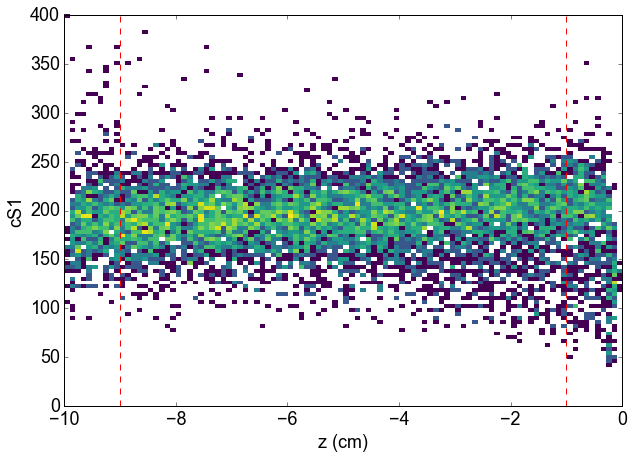

In [74]:
plt.hist2d(d['z'], d['cs1'], bins=100, norm=LogNorm(), range=((-10, 0), (0, 400)))
plt.xlabel('z (cm)')
plt.ylabel('cS1')
for l in (-9, -1):
    plt.axvline(l, ls='--', color='red')
plt.show()

### Fiducial volume

In [75]:
d_cs = cuts.range_selection(d_cs, 'z', (-9, -1))

z in [-9, -1) selection: 16166 rows removed (79.53% passed)


### S2 top PMT saturation (or: saturation correction)

If we look at the S2 AFT versus S2 size, there is a decrease noticable starting at roughly 25k p.e.. We can correct for this effect by using the bottom PMT channel only. What is equivalent to this is up-correcting the S2 by assuming that the S2 AFT has to be some fixed value (I use the value at 10k p.e. here). The only difference with only the bottom PMT is a scaling.

In [76]:
x, y = get_trend(d_cs['s2'], d_cs['s2_area_fraction_top'],(1e3, 60e3), 60, mode='mean')
f_s2_aft = my_interp(x, y,kind='cubic')
pickle.dump((x, y), open('xy_cs_s2aft', 'wb'))

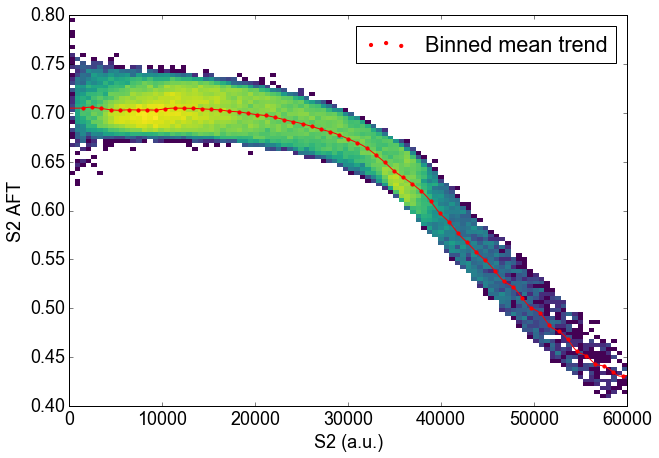

In [77]:
plt.hist2d(d_cs['s2'], d_cs['s2_area_fraction_top'], bins=100, range=((0, 60e3), (0.4, 0.8)), norm=LogNorm())
plt.scatter(x, y, s=10, label='Binned mean trend', color='red')
x_plot = np.linspace(0, 60e3, 400)
plt.plot(x_plot, f_s2_aft(x_plot), color='red')
plt.legend()
plt.xlabel('S2 (a.u.)')
plt.ylabel('S2 AFT')
plt.show()

In [78]:
d_cs['s2_bottom'] = d_cs['s2'] * (1-d_cs['s2_area_fraction_top'])
f_s2_aft(10e3)
d_cs['cs2'] = ((1-d_cs['s2_area_fraction_top']) / (1-f_s2_aft(10e3))) * d_cs['s2']
# Cross-check: aft based on this value should always be the same
d_cs['aft_fixed'] = (d_cs['cs2'] - d_cs['s2_bottom']) / (d_cs['cs2'])
print(np.unique(d_cs['aft_fixed'].values))

[ 0.70364914  0.70364914  0.70364914]


Now let's compare the two specta...

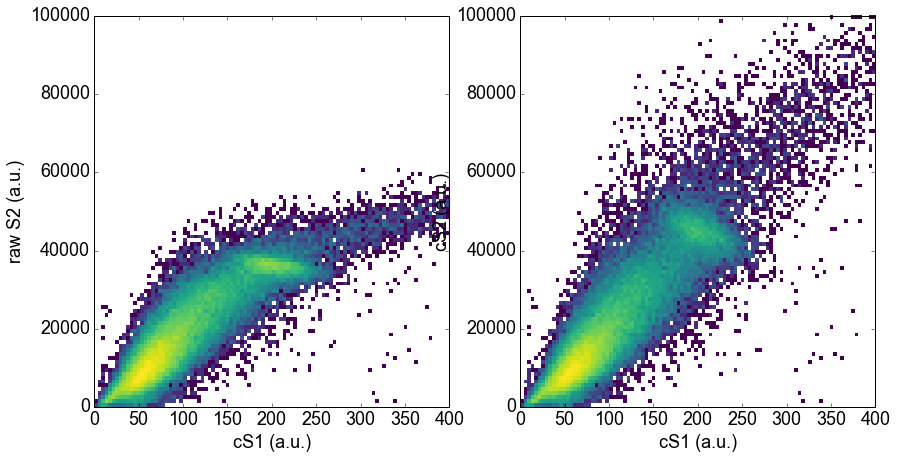

In [79]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.hist2d(d_cs['cs1'], d_cs['s2'], bins=100, norm=LogNorm(), range=((0, 400), (0, 100e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('raw S2 (a.u.)')

plt.subplot(122)
plt.hist2d(d_cs['cs1'], d_cs['cs2'], bins=100, norm=LogNorm(), range=((0, 400), (0, 100e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('cS2 (a.u.)')


plt.show()

### S2 electron lifetime

#### Data selection

We want to select the photopeak. First selection based on the cS1

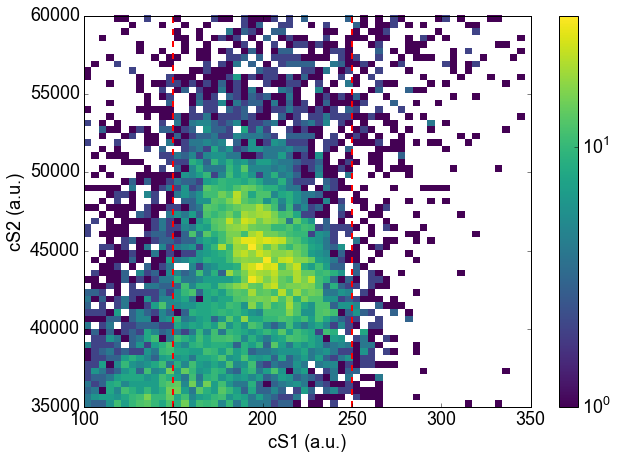

In [80]:
plt.hist2d(d_cs['cs1'], d_cs['cs2'], bins=60, norm=LogNorm(), range=((100, 350), (35e3, 60e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('cS2 (a.u.)')
plt.colorbar()
for l in (150, 250):
    plt.axvline(l, ls='--', lw=2, color='red')
plt.show()

In [81]:
d = deepcopy(d_cs)
d = cuts.range_selection(d, 'cs1', (150, 250))

cs1 in [150, 250) selection: 51711 rows removed (17.68% passed)


Now remove outliers...

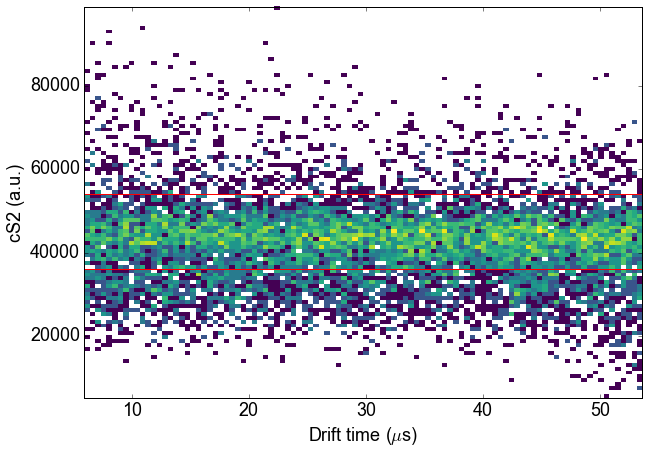

In [82]:
plt.hist2d(d['drift_time'], d['cs2'], bins=100, norm=LogNorm())
plt.axhline(36e3, color='red')
plt.axhline(54e3, color='red')
plt.xlabel('Drift time ($\mu$s)')
plt.ylabel('cS2 (a.u.)')
plt.show()

In [83]:
d = cuts.range_selection(d, 'cs2', (36e3, 54e3))

cs2 in [36000.0, 54000.0) selection: 3702 rows removed (66.67% passed)


#### Fit - unbinned

In [84]:
def f_s2(x, a0, tau):
    return a0 * np.exp(-x/tau)

In [85]:
popt_unbinned, pcov_unbinned = scipy.optimize.curve_fit(f_s2, d['drift_time'], d['cs2'], p0=[45000, 200])
perr_unbinned = np.sqrt(np.diag(pcov_unbinned))

#### Fit - binned

In [86]:
x, y = get_trend(d['drift_time'], d['cs2'], 
              x_range=(min(d['drift_time']), max(d['drift_time'])), bins=10, mode='median')

In [87]:
popt_binned, pcov_binned = scipy.optimize.curve_fit(f_s2,x, y, p0=[45000, 200])
perr_binned = np.sqrt(np.diag(pcov_binned))
popt_binned

array([ 44503.0456375 ,   2284.19763524])

In [88]:
print('Unbinned fit: %.1f +- %.1f us' % (popt_unbinned[1], perr_unbinned[1]))
print('Binned fit:   %.1f +- %.1f us' % (popt_binned[1], perr_binned[1]))

Unbinned fit: 2322.9 +- 435.9 us
Binned fit:   2284.2 +- 408.9 us


#### The results

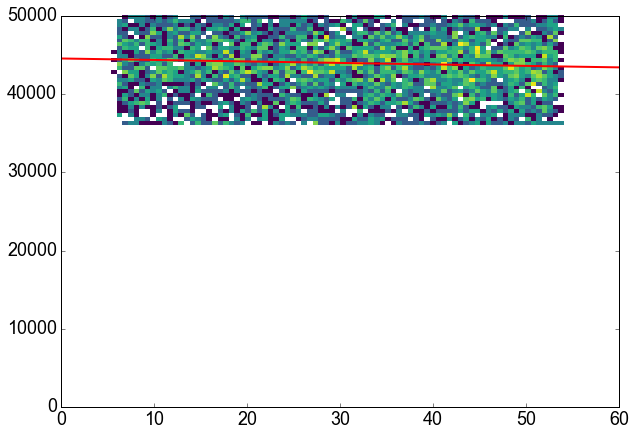

In [89]:
plt.hist2d(d['drift_time'], d['cs2'], bins=100, norm=LogNorm(), range=((0, 60), (0, 50e3)))
x_plot = np.linspace(0, 60, 200)
plt.plot(x_plot, f_s2(x_plot, popt_unbinned[0], popt_unbinned[1]), color='red', lw=2)
plt.show()

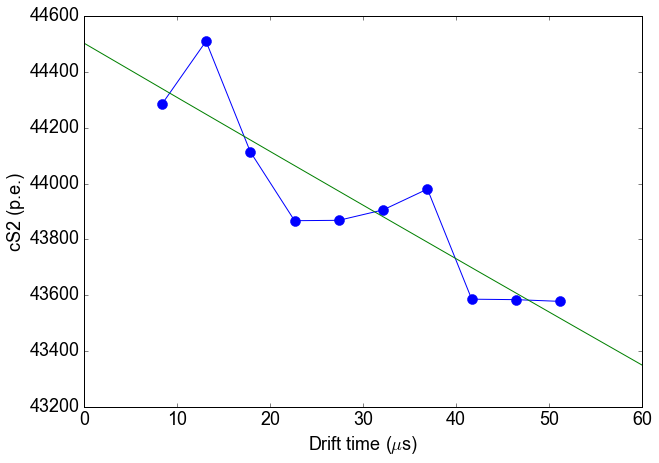

In [90]:
plt.plot(x, y, marker='.', markersize=20)
x_plot= np.linspace(0, 60, 200)
plt.plot(x_plot, f_s2(x_plot, popt_binned[0], popt_binned[1]))
plt.xlabel('Drift time ($\mu$s)')
plt.ylabel('cS2 (p.e.)')
plt.show()

#### Apply correction

In [97]:
d_cs['ccs2'] = d_cs['cs2'] * np.exp(d_cs['drift_time'] / popt_unbinned[1])
d_cs['s2_bottom'] = d_cs['s2'] * (1 - d_cs['s2_area_fraction_top'])
d_cs['cs2_bottom'] = d_cs['s2_bottom'] * np.exp(d_cs['drift_time'] / popt_unbinned[1])


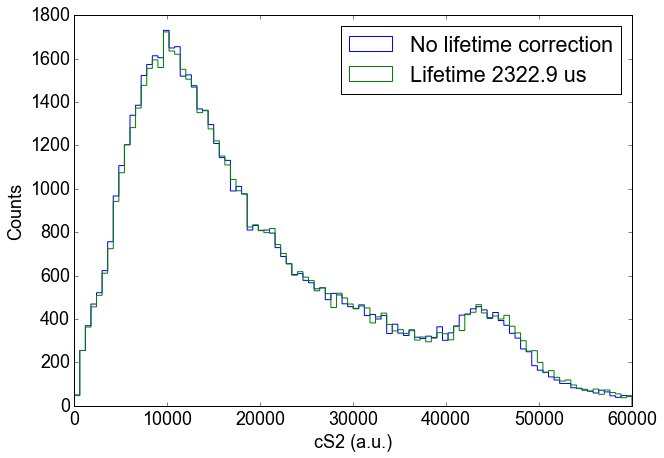

In [92]:
plt.hist(d_cs['cs2'], bins=100, histtype='step', range=(0, 60e3), label='No lifetime correction')
plt.hist(d_cs['ccs2'], bins=100, histtype='step', range=(0, 60e3), label='Lifetime %.1f us' % (popt_unbinned[1]))
plt.xlabel('cS2 (a.u.)')
plt.ylabel('Counts')
plt.legend()
plt.show()

#### Note to self...

The lifetime seems to jump up and down a lot based on different data selections...
Are these two values too close to each other to be correct?

## 2D fit

### Settings

In [103]:
use_bottom = True
cs1_range = (125, 275)
cs1_bins = 40
cs2_bins = 40

if use_bottom:
    cs2_range = (10e3, 17e3)
else:
    cs2_range = (30e3, 60e3)

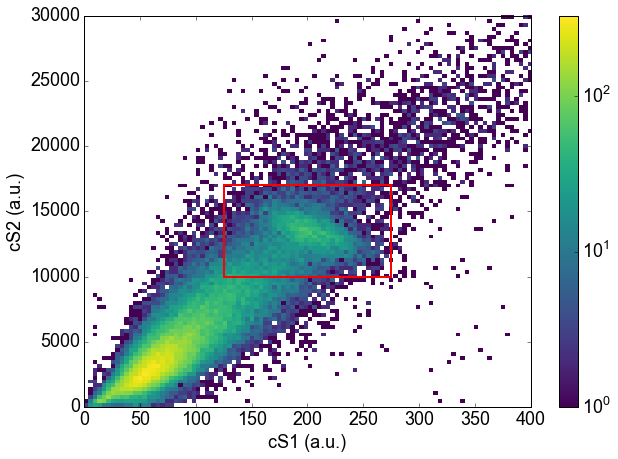

In [104]:
if use_bottom:
    plt.hist2d(d_cs['cs1'], d_cs['cs2_bottom'], bins=100, norm=LogNorm(), range=((0, 400), (0, 30e3)))
else:
    plt.hist2d(d_cs['cs1'], d_cs['ccs2'], bins=100, norm=LogNorm(), range=((0, 400), (0, 100e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('cS2 (a.u.)')
draw_box(cs1_range, cs2_range, edgecolor='red', lw=2)
plt.colorbar()
plt.show()

### Build data to fit

In [105]:
def build_fit_lists(x, y, x_range, y_range, x_bins, y_bins):
    x_bin_edges = np.linspace(x_range[0], x_range[1], x_bins+1)
    y_bin_edges = np.linspace(y_range[0], y_range[1], y_bins+1)
    
    
    # Loop over all bins first in x then in y and count the number of entries in that bin
    # Slightly inefficient code
    counts = []
    for left_y, right_y in zip(y_bin_edges[:-1], y_bin_edges[1:]):
        x_sub = x[(y >= left_y) & (y < right_y)]
        for left_x, right_x in zip(x_bin_edges[:-1], x_bin_edges[1:]):
            counts.append(sum((x_sub >= left_x) & (x_sub < right_x)))
    
    
    
    x_list = [0.5*(left_x + right_x)
              for left_y, right_y in zip(y_bin_edges[:-1], y_bin_edges[1:])
              for left_x, right_x in zip(x_bin_edges[:-1], x_bin_edges[1:])
              ]
    y_list = [0.5*(left_y + right_y)
              for left_y, right_y in zip(y_bin_edges[:-1], y_bin_edges[1:])
              for left_x, right_x in zip(x_bin_edges[:-1], x_bin_edges[1:])
              ]
    
    return np.array(counts), np.array(x_list), np.array(y_list)
    

In [106]:
if use_bottom:
    counts, x_fit, y_fit = build_fit_lists(d_cs['cs1'], d_cs['cs2_bottom'], cs1_range, cs2_range, cs1_bins, cs2_bins)
else:
    counts, x_fit, y_fit = build_fit_lists(d_cs['cs1'], d_cs['ccs2'], cs1_range, cs2_range, cs1_bins, cs2_bins)

### Additional cuts

In [117]:
if use_bottom:
    # what is the slope? The answer is 42
    def cut1(x):
        return 20e3 - 42*x   
    def cut2(x):
        return 24e3 - 42*x
else:
    def cut1(x):
        return 66e3 - 150*x
    def cut2(x):
        return 83e3 - 150*x

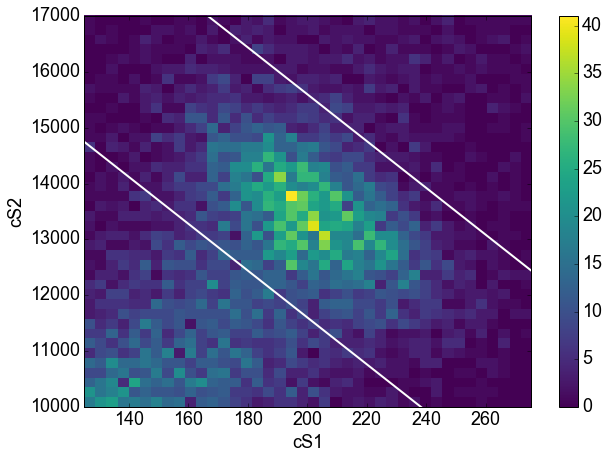

In [118]:
# plt.scatter(x_fit, y_fit, c=counts)
if use_bottom:
    plt.hist2d(d_cs['cs1'], d_cs['cs2_bottom'], bins=(cs1_bins, cs2_bins), range=(cs1_range, cs2_range))#, norm=LogNorm())
else:
    plt.hist2d(d_cs['cs1'], d_cs['ccs2'], bins=(cs1_bins, cs2_bins), range=(cs1_range, cs2_range))#, norm=LogNorm())
x_plot = np.linspace(100,300, 20)
for cut in [cut1, cut2]:
    plt.plot(x_plot, cut(x_plot), color='white', lw=2)
plt.colorbar()
plt.xlabel('cS1')
plt.ylabel('cS2')
plt.show()

In [119]:
sel = (cut1(x_fit) < y_fit) & (cut2(x_fit) > y_fit)

### Fit!

In [120]:
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g #.ravel()

In [121]:
if use_bottom:
    initial_guess = (20,200,13500,30,2000,-0.03,0)
else:
    initial_guess = (20,200,45000,30,2000,-0.03,0)

popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x_fit[sel], y_fit[sel]), counts[sel], p0=initial_guess)
print('cS1 peak position: %.1f' % (popt[1]))
print('cS2 peak position: %.1f' % (popt[2]))


cS1 peak position: 200.2
cS2 peak position: 13425.5


In [122]:
print(popt)

[  2.74646637e+01   2.00154688e+02   1.34255152e+04   2.04301363e+01
   1.11735108e+03  -1.04839546e-02   5.77993806e-01]


## The sweet sweet plot

In [126]:
delta1 = 1
delta2 = 100
x = np.arange(150.0, 250, delta1)
if use_bottom:
    y = np.arange(10000, 17000, delta2)
else:
    y = np.arange(33000, 60000, delta2)

X, Y = np.meshgrid(x, y)
Z = twoD_Gaussian((X,Y), *popt)

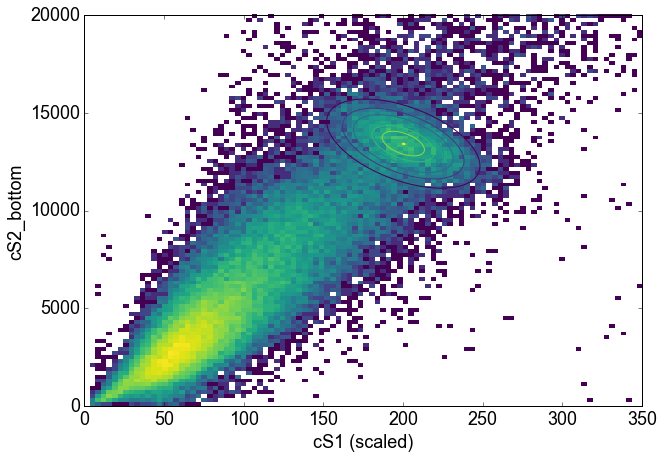

In [130]:
plt.contour(X, Y, Z, c='white')
if use_bottom:
    plt.hist2d(d_cs['cs1'], d_cs['cs2_bottom'], bins=100, norm=LogNorm(), range=((0, 350), (0, 20e3)))
else:
    plt.hist2d(d_cs['cs1'], d_cs['ccs2'], bins=100, norm=LogNorm(), range=((0, 350), (0, 70e3)))
plt.xlabel('cS1 (scaled)')
if use_bottom:
    plt.ylabel('cS2_bottom')
else:
    plt.ylabel('cS2 (scaled)')
plt.savefig('cs137_cs1cs2.png', bbox_inches='tight')
plt.savefig('cs137_cs1cs2.pdf', bbox_inches='tight')
plt.show()